<h2 style="text-align: center;"><span style="color: #333399;">Lab Course: Distributed Data Analytics</span><br /><span style="color: #333399;">Exercise Sheet 7</span></h2>
<h3 style="text-align: center;"><span style="color: #333399;">Syed Wasif Murtaza Jafri- 311226</span></h3>

## Network Analysis: Image Classification - Part 2
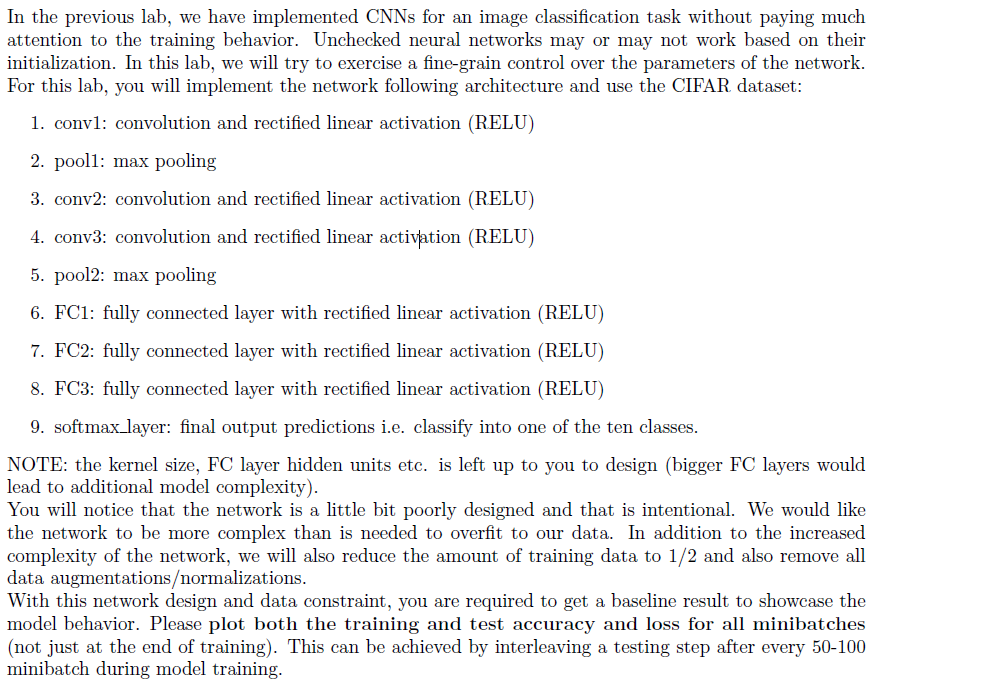


In [5]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader,Dataset  # Gives easier dataset managment by creating mini batches etc.
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
import torch.nn.functional as F
import torchvision

import random
from timeit import default_timer as timer


In [54]:
def calculateMeanStd(cifar_trainset):
    images = [item[0] for item in cifar_trainset] 
    images = torch.stack(images, dim=0).numpy()

    mean_r = images[:,0,:,:].mean()
    mean_g = images[:,1,:,:].mean()
    mean_b = images[:,2,:,:].mean()

    # calculate std over each channel (r,g,b)
    std_r = images[:,0,:,:].std()
    std_g = images[:,1,:,:].std()
    std_b = images[:,2,:,:].std()

    return [mean_r,mean_g,mean_b],[std_r,std_g,std_b]

In [8]:
def accuracy(outputs, labels):
    ''' Calculating accuray of prediction'''
    
    _, preds = torch.max(outputs, dim = 1) # class with highest probablity is the predicted output
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

In [9]:
def trainModel(model,optimizer,criterion,learning_rate,train_loader,test_loader,num_epochs,desc):
    layout = {
    "Performance on training and test data": {
        "loss": ["Multiline", ["loss/train", "loss/test"]],
        "accuracy": ["Multiline", ["accuracy/train", "accuracy/test"]],
    },
    }
    writer = SummaryWriter(f'runs/{desc}/')
    writer.add_custom_scalars(layout)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        lossSum = 0
        accSum = 0

        # iterating through all batches
        for i,sample_batched in enumerate(train_loader):

            # setting gradient to zero before forward pass
            optimizer.zero_grad()

            # model predict
            yhat=model(sample_batched[0].cuda())

            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            lossSum += loss.item()

            # model accuracy
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())

            accSum += acc.item()

            # calculating gradient through backprop
            loss.backward(retain_graph=True)

            # updating parameters
            optimizer.step()
                    # writing accuracy and loss to tensorboard logs
        lossAvg = lossSum /len(train_loader)
        accAvg = accSum/len(train_loader)
        writer.add_scalar("loss/train", lossAvg, epoch)
        writer.add_scalar("accuracy/train",accAvg, epoch)
        
        testAcc,testLoss = evalModel(model,optimizer,criterion,test_loader,epoch,writer)

        if (epoch+1) % 5 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {lossAvg:.4f},Train Accuracy: {accAvg:.4f},Test Loss: {testLoss:.4f},Test Accuracy: {testAcc:.4f}')

    writer.flush()
    print('Finished Training')
    return model
def evalModel(model,optimizer,criterion,test_loader,epoch,writer):
    accSum = 0
    lossSum = 0
    # for evaluating model on test data with no gradient calculation
    with torch.no_grad():
        for i,sample_batched in enumerate(test_loader):
            # setting gradient to zero before forward pass
            optimizer.zero_grad()

            # model predict
            yhat=model(sample_batched[0].cuda())

            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            lossSum += loss
            # model acc
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            accSum += acc

            # writing accuracy and loss to tensorboard logs
    
    totalloss = lossSum/len(test_loader)
    totalAccuracy = accSum/len(test_loader)
    if(writer!=None):
        writer.add_scalar("loss/test", totalloss, epoch)
        writer.add_scalar("accuracy/test",totalAccuracy, epoch)

    
    return totalAccuracy.item(),totalloss.item()

In [12]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_of_classes=10):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()

        self.conv1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 16,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.conv3 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.FC1 = nn.Linear(64*3*3,1024)
        self.FC2 = nn.Linear(1024,512)
        self.FC3= nn.Linear(512,256)
        self.Output = nn.Linear(256,10)
       
        
    def forward(self,x):
  
        x = self.relu(self.conv1(x))
        x = self.pool1(x) 
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool1(x)
        
        x = x.view(-1, 64 *3* 3)  
        
        x = self.relu(self.FC1(x))
        x = self.relu(self.FC2(x))
        x = self.relu(self.FC3(x))
        
        x = self.softmax(self.Output(x))
        
        return x

In [14]:
torch.cuda.empty_cache()

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 30
batch_size= 512

transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=True)
# spliting dataset into half with random indexes
indexList = random.sample(list(range(0,len(train_dataset))), (len(train_dataset)//2))
train_dataset_half = torch.utils.data.Subset(train_dataset,indexList)

test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform,download=True)
train_loader = DataLoader(dataset=train_dataset_half,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

# different setting of learning rates
learning_rate =0.001

criterion = nn.NLLLoss()
    
# Initialize network
model = CNN(input_channels=in_channels, num_of_classes=num_classes).to(device)

# Initializing Optimizer
optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)

# Initializing writer for tensorboard
desc = 'Baseline'+'_'+str(num_epochs)

print('--------------------------------------------------')
print('|--------------Baseline Experiment ---------------|')
print('--------------------------------------------------')
model = trainModel(model, optimizer,criterion, learning_rate, train_loader,test_loader, num_epochs, desc)


cuda
Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------
|--------------Baseline Experiment ---------------|
--------------------------------------------------
Epoch [5/30],Train Loss: 1.5031,Train Accuracy: 0.4488,Test Loss: 1.5002,Test Accuracy: 0.4415
Epoch [10/30],Train Loss: 1.2029,Train Accuracy: 0.5685,Test Loss: 1.2735,Test Accuracy: 0.5408
Epoch [15/30],Train Loss: 0.9874,Train Accuracy: 0.6480,Test Loss: 1.2046,Test Accuracy: 0.5776
Epoch [20/30],Train Loss: 0.7771,Train Accuracy: 0.7231,Test Loss: 1.1815,Test Accuracy: 0.5998
Epoch [25/30],Train Loss: 0.5510,Train Accuracy: 0.8044,Test Loss: 1.4008,Test Accuracy: 0.5939
Epoch [30/30],Train Loss: 0.2882,Train Accuracy: 0.9018,Test Loss: 1.7907,Test Accuracy: 0.5904
Finished Training


#### Baseline
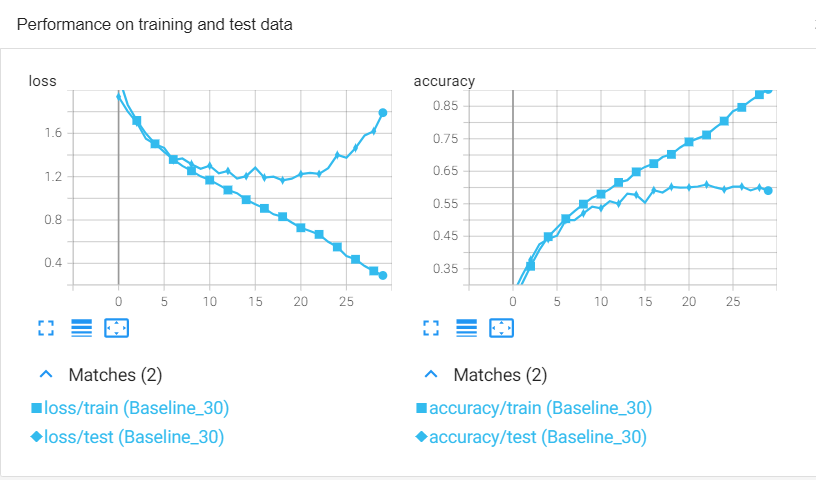

<b>Comment</b> : Model is overfitting training data after 15 epochs as test loss is increasing and test accuracy becomes constant and training accuracy increases.

## Exercise 1: Normalization Effect
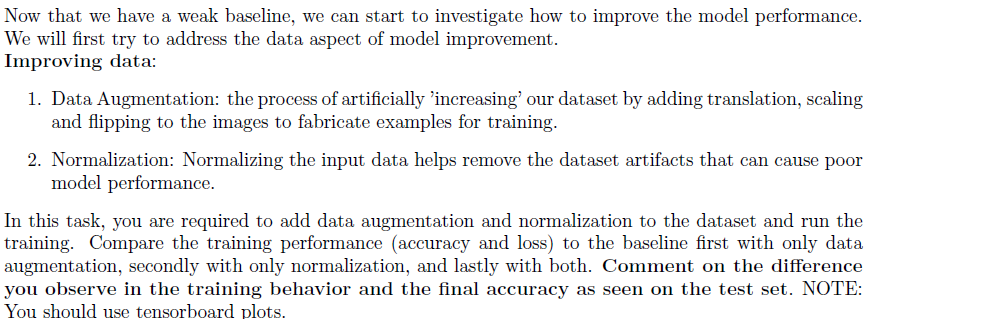

In [51]:
def getTrainData(augm,norm):
    ## calculating mean and std for normalization
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    train_data = datasets.CIFAR10(root="dataset/", train=True,transform=transform,download=False)
    meanPerChannel,stdPerChannel =calculateMeanStd2(train_data)
    
    if augm == True and norm==False:
        transform = transforms.Compose([transforms.Resize((32,32)),
            transforms.ToTensor(),
        ])
        train_dataset_org = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=False)
        transform = transforms.Compose([transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.ColorJitter(hue=.05, saturation=.05),
            transforms.RandomHorizontalFlip(),
        ])
        train_dataset_aug = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=False)
        train_dataset = torch.utils.data.ConcatDataset([train_dataset_org, train_dataset_aug])
        desc = ' with_Augmentation_Only'
        
    elif augm == False and norm==True:
        transform = transforms.Compose([transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=  meanPerChannel, std=stdPerChannel)
    ])
        train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=False)
        meanPerChannel2,stdPerChannel2 =calculateMeanStd(train_dataset)
        desc = ' with_Normalization_Only'
        
        
    elif augm == True and norm==True:
        transform = transforms.Compose([transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=  meanPerChannel, std=stdPerChannel)
        ])
        train_dataset_org = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=False)
        transform = transforms.Compose([transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.ColorJitter(hue=.05, saturation=.05),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=  meanPerChannel, std=stdPerChannel)
        ])
        train_dataset_aug = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=False)
        train_dataset = torch.utils.data.ConcatDataset([train_dataset_org, train_dataset_aug])
        desc = ' with_both_Augmentation_and_Normalization'
    return train_dataset,desc,meanPerChannel,stdPerChannel,transform

In [53]:
# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 30
batch_size= 512
config_aug_norm =[(True,False),(False,True),(True,True)]

for augm,norm in config_aug_norm:
    
    # getting training and test data
    train_dataset,desc,meanPerChannel,stdPerChannel,transform = getTrainData(augm,norm)
    # using same tranform for test
    test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform,download=False)
    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

    # different setting of learning rates
    learning_rate = 0.001
    n_total_steps = len(train_loader)
    criterion = nn.NLLLoss()

    # Initialize network
    model = CNN(input_channels=in_channels, num_of_classes=num_classes).to(device)

    # Initializing Optimizer
    optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)

    # Initializing writer for tensorboard

    print('--------------------------------------------------')
    print('|------Experiment'+str(desc)+'--------|')
    print('--------------------------------------------------')

    model = trainModel(model, optimizer,criterion, learning_rate, train_loader,test_loader, num_epochs, desc)


--------------------------------------------------
|------Experiment with_Augmentation_Only--------|
--------------------------------------------------
Epoch [5/30],Train Loss: 1.0352,Train Accuracy: 0.6310,Test Loss: 1.0736,Test Accuracy: 0.6222
Epoch [10/30],Train Loss: 0.6948,Train Accuracy: 0.7563,Test Loss: 0.9453,Test Accuracy: 0.6748
Epoch [15/30],Train Loss: 0.4347,Train Accuracy: 0.8520,Test Loss: 1.0892,Test Accuracy: 0.6884
Epoch [20/30],Train Loss: 0.2583,Train Accuracy: 0.9152,Test Loss: 1.2546,Test Accuracy: 0.6787
Epoch [25/30],Train Loss: 0.1595,Train Accuracy: 0.9483,Test Loss: 1.4912,Test Accuracy: 0.6806
Epoch [30/30],Train Loss: 0.1197,Train Accuracy: 0.9611,Test Loss: 1.7120,Test Accuracy: 0.6782
Finished Training
--------------------------------------------------
|------Experiment with_Normalization_Only--------|
--------------------------------------------------
Epoch [5/30],Train Loss: 0.9828,Train Accuracy: 0.6494,Test Loss: 1.0373,Test Accuracy: 0.6287
Epoch [

#### With Augmentation Only
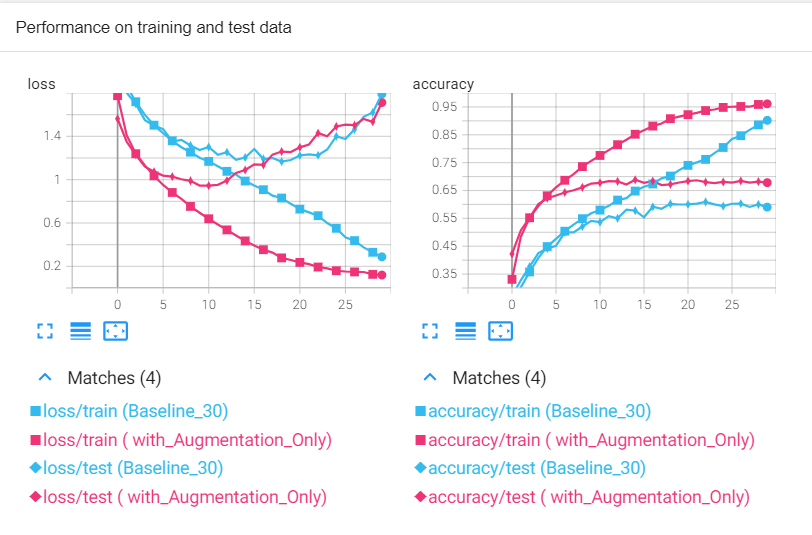

<b>Comment</b> : With data augmentation, more data is available for training and overfitting is reduced. also test accuracy is increased in comparison with baseline.

#### With Normalization Only
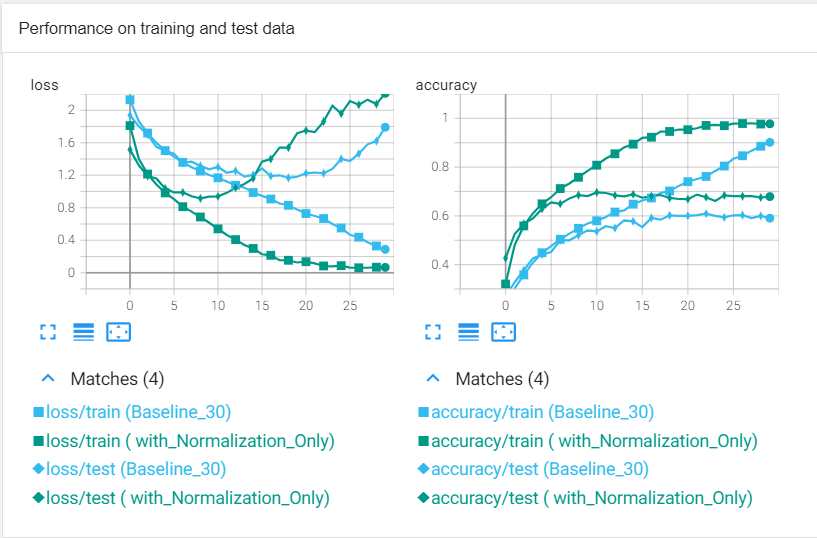

<b>Comment</b> : With normalization model is trained quickly in just around 10 epochs, in later epochs it is overfitting but overall test accuracy is better than baseline.

#### With both Augmentation and Normalization
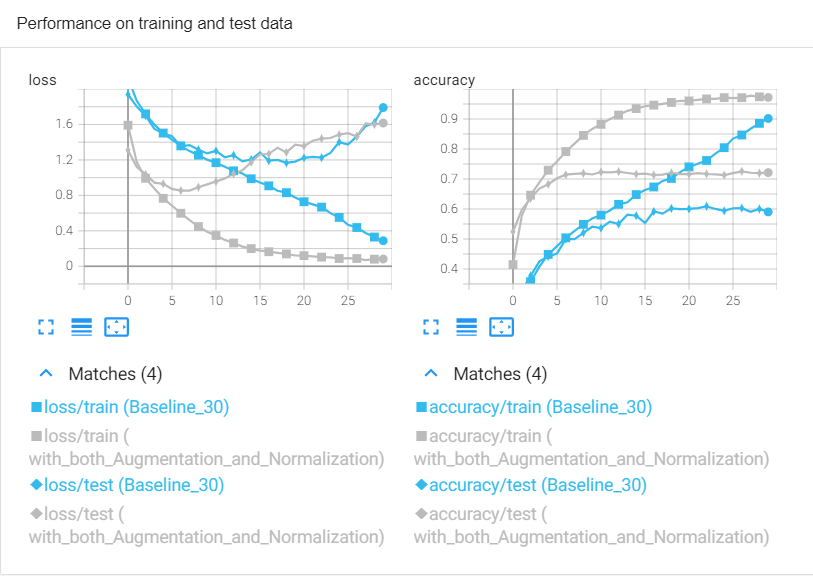

<b>Comment</b> : When both normalization and augmentation of data is combined it gives the best result.Model is trained quickly also reduces overfitting resulting in better test accuracy than baseline.

#### Exercise 2: Network Regularization
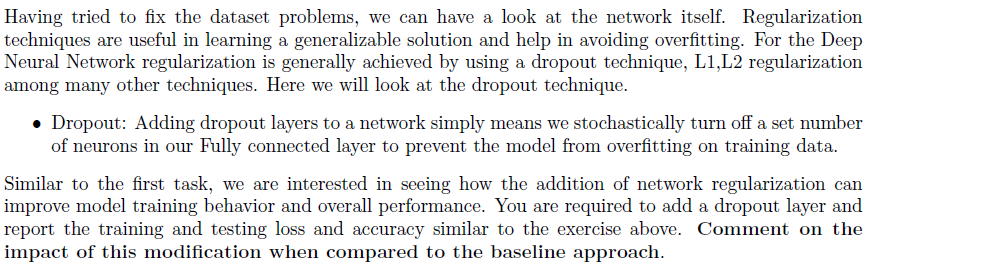

In [27]:
class CNNwithDropout(nn.Module):
    def __init__(self, input_channels=1, num_of_classes=10,dropout=0.5):
        super(CNNwithDropout, self).__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()
        self.dropout = dropout

        self.conv1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 64,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(
            in_channels = 64,
            out_channels = 128,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.dropout1 = nn.Dropout(self.dropout)
        self.dropout2 = nn.Dropout(self.dropout-0.1)
        self.dropout3 = nn.Dropout(self.dropout-0.2)
        self.FC1 = nn.Linear(256*3*3,512)
        self.FC2 = nn.Linear(512,256)
        self.FC3= nn.Linear(256,84)
        
    def forward(self,x):
  
        x = self.relu(self.conv1(x)) # dimension after : [1, 6, 28, 28]
        x = self.pool1(x) # dimension after : [1, 6, 14, 14]
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))# dimension after : [1, 16,10, 10]
        x = self.pool1(x)
        #print(x.shape)
        # flattening dimension (120,1,1) to 120
        x = x.view(-1, 256 *3* 3)  # dimension after : [1, 120]
        
        x = self.dropout1(x)
        x = self.relu(self.FC1(x))
        x = self.dropout2(x)
        x = self.relu(self.FC2(x))
        x = self.dropout3(x)
        x = self.relu(self.FC3(x))# dimension after : [1, 84]
        x = self.softmax(x)  # dimension after : [1, 10]

        
        return x

In [28]:
# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 30
batch_size= 512

transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform,download=True)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

# different setting of learning rates
learning_rate =0.001
n_total_steps = len(train_loader)
criterion = nn.NLLLoss()
dropoutList = [0.3,0.4,0.5]

for dropout in dropoutList:
    desc = 'Dropout_'+str(dropout)
    # Initialize network
    model = CNNwithDropout(input_channels=in_channels, num_of_classes=num_classes,dropout = dropout).to(device)

    # Initializing Optimizer
    optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)



    print('--------------------------------------------------')
    print('|------ Experiment with Dropout = '+str(dropout)+'--------|')
    print('--------------------------------------------------')

    
    model = trainModel(model, optimizer,criterion, learning_rate, train_loader,test_loader, num_epochs, desc)

    writer = None
    epoch = None
    totalAccuracy = evalModel(model,optimizer,criterion,test_loader,epoch,writer)
    print('Final test Accuracy'+desc+':'+str(totalAccuracy))


Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------
|------ Experiment with Dropout = 0.3--------|
--------------------------------------------------
Epoch [5/30],Train Loss: 1.3943,Train Accuracy: 0.4873,Test Loss: 1.3714,Test Accuracy: 0.4958
Epoch [10/30],Train Loss: 1.0138,Train Accuracy: 0.6371,Test Loss: 1.0436,Test Accuracy: 0.6252
Epoch [15/30],Train Loss: 0.7931,Train Accuracy: 0.7217,Test Loss: 0.8894,Test Accuracy: 0.6893
Epoch [20/30],Train Loss: 0.6300,Train Accuracy: 0.7808,Test Loss: 0.8298,Test Accuracy: 0.7244
Epoch [25/30],Train Loss: 0.5106,Train Accuracy: 0.8209,Test Loss: 0.8725,Test Accuracy: 0.7202
Epoch [30/30],Train Loss: 0.4161,Train Accuracy: 0.8544,Test Loss: 0.8657,Test Accuracy: 0.7363
Finished Training
Final test AccuracyDropout_0.3:(0.7333179712295532, 0.8759010434150696)
--------------------------------------------------
|------ Experiment with Dropout = 0.4--------|
------------

#### Comparison with Baseline
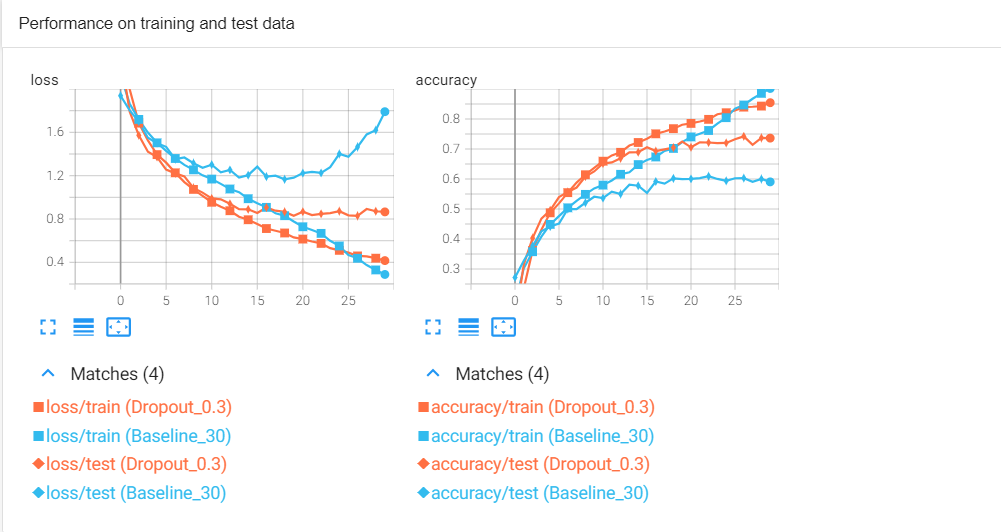

<b>Comment</b> : When comparing with baseline, test accuracy increases after adding dropout because it regularizes the neurons in layers and model does not overfit the training data, which was the the case in baseline after 15 epochs as test loss is increasing.

#### Comparison with different dropouts
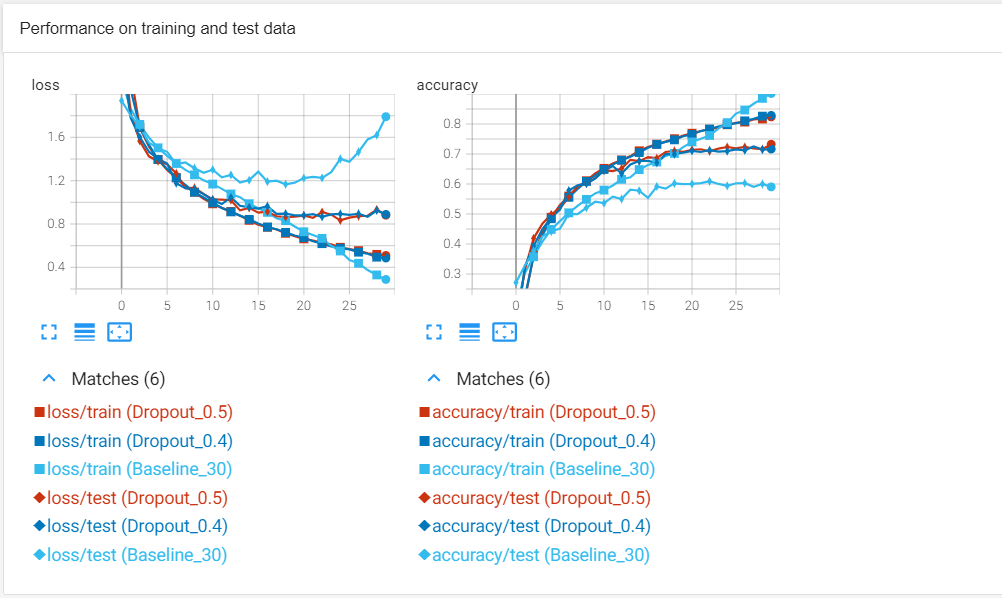

<b>Comment</b> : When experimenting with different dropout rates, test accuracy is best for dropout=0.5.

### Bonus
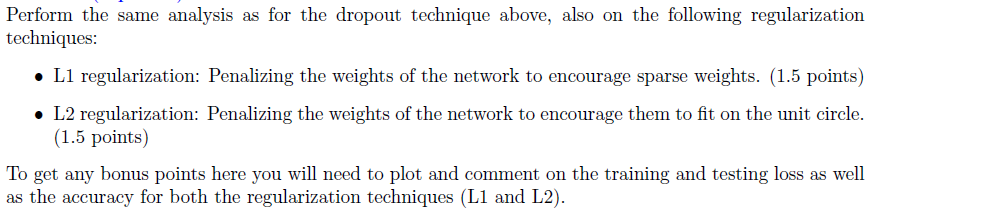

In [18]:
def trainModelRegularizer(model,optimizer,criterion,learning_rate,train_loader,test_loader,num_epochs,desc,regularizer,lambda1):
    layout = {
    "Performance on training and test data": {
        "loss": ["Multiline", ["loss/train", "loss/test"]],
        "accuracy": ["Multiline", ["accuracy/train", "accuracy/test"]],
    },
    }
    writer = SummaryWriter(f'runs/{desc}/')
    writer.add_custom_scalars(layout)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        lossSum = 0
        accSum = 0

        # iterating through all batches
        for i,sample_batched in enumerate(train_loader):

            # setting gradient to zero before forward pass
            optimizer.zero_grad()

            # model predict
            yhat=model(sample_batched[0].cuda())

            # model loss
            nLLLoss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            all_linear1_params = torch.cat([x.view(-1) for x in model.FC1.parameters()])
            l1_regularization = lambda1 * torch.norm(all_linear1_params, regularizer)
            #l1_norm = sum(p.abs().sum() for p in model.parameters())
        
            loss = nLLLoss + l1_regularization 
            lossSum += loss.item()

            # model accuracy
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())

            accSum += acc.item()

            # calculating gradient through backprop
            loss.backward(retain_graph=True)

            # updating parameters
            optimizer.step()
                    # writing accuracy and loss to tensorboard logs
        lossAvg = lossSum /len(train_loader)
        accAvg = accSum/len(train_loader)
        writer.add_scalar("loss/train", lossAvg, epoch)
        writer.add_scalar("accuracy/train",accAvg, epoch)
        
        testAcc,testLoss = evalModel(model,optimizer,criterion,test_loader,epoch,writer)

        if (epoch+1) % 5 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {lossAvg:.4f},Train Accuracy: {accAvg:.4f},Test Loss: {testLoss:.4f},Test Accuracy: {testAcc:.4f}')

    writer.flush()
    print('Finished Training')
    return model

In [19]:
# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 30
batch_size= 512

transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=True)
# spliting dataset into half with random indexes
indexList = random.sample(list(range(0,len(train_dataset))), (len(train_dataset)//2))
train_dataset_half = torch.utils.data.Subset(train_dataset,indexList)

test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform,download=True)
train_loader = DataLoader(dataset=train_dataset_half,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

config =[(1,0.05),(1,0.01),(1,0.001),(2,0.05),(2,0.01),(2,0.001)]
# different setting of learning rates
learning_rate =0.001

criterion = nn.NLLLoss()
for regularizer,lamda in config:    
    # Initialize network
    model = CNN(input_channels=in_channels, num_of_classes=num_classes).to(device)

    # Initializing Optimizer
    optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)

    # Initializing writer for tensorboard
    desc = 'L'+str(regularizer)+'_'+str(lamda)

    print('--------------------------------------------------')
    print('|--------------'+desc+' Experiment ---------------|')
    print('--------------------------------------------------')
    model = trainModelRegularizer(model, optimizer,criterion, learning_rate, train_loader,test_loader, num_epochs, desc,regularizer,lamda)


cuda
Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------
|--------------L1_0.05 Experiment ---------------|
--------------------------------------------------
Epoch [5/30],Train Loss: 5.7393,Train Accuracy: 0.1039,Test Loss: 2.3022,Test Accuracy: 0.1039
Epoch [10/30],Train Loss: 5.2505,Train Accuracy: 0.2108,Test Loss: 1.9218,Test Accuracy: 0.2018
Epoch [15/30],Train Loss: 5.1509,Train Accuracy: 0.2268,Test Loss: 1.8809,Test Accuracy: 0.2306
Epoch [20/30],Train Loss: 5.1308,Train Accuracy: 0.2445,Test Loss: 1.8551,Test Accuracy: 0.2376
Epoch [25/30],Train Loss: 5.0988,Train Accuracy: 0.2566,Test Loss: 1.8329,Test Accuracy: 0.2596
Epoch [30/30],Train Loss: 5.0603,Train Accuracy: 0.2731,Test Loss: 1.7930,Test Accuracy: 0.2763
Finished Training
--------------------------------------------------
|--------------L1_0.01 Experiment ---------------|
--------------------------------------------------
Epoch [5/30],Train L

#### L1 regularization with different Lambda
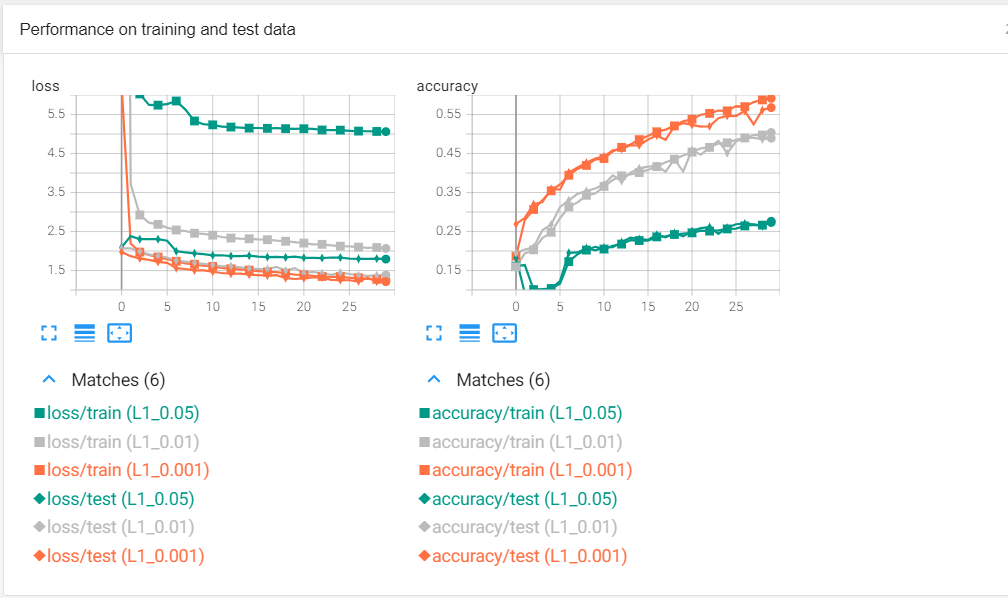

<b>Comment</b> : Model is not overfitting after L1 regularization and test and training accuracy curves are very close for every value of lambda.Best result is achieved with smaller labmda 0.001


#### L2 regularization with different Lambda
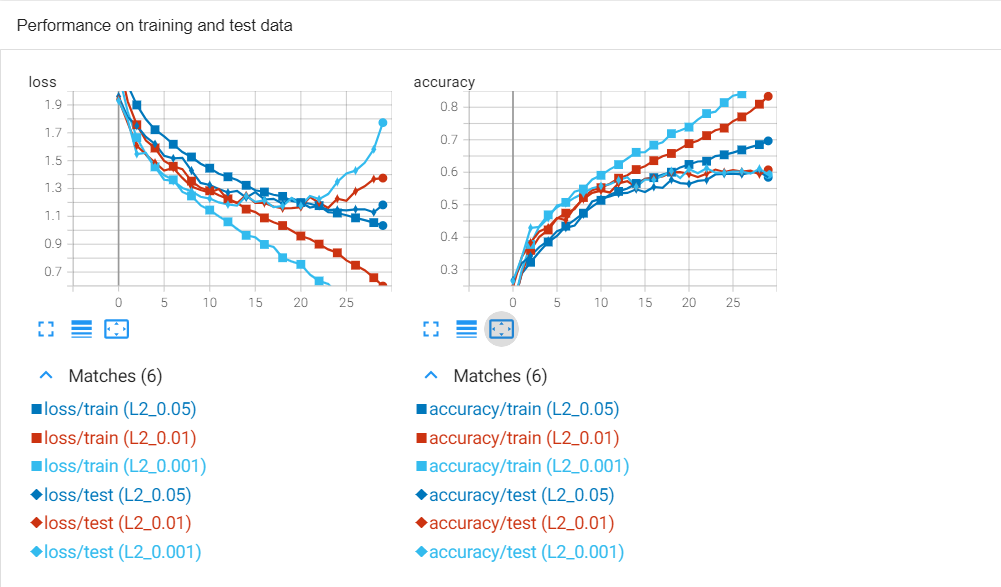

<b>Comment</b> : for value of lambda 0.05 , training and test curves are closer and hence with low variance it is not overfitting as much as compared to other values of lambda.

## Exercise 3: Optimizers
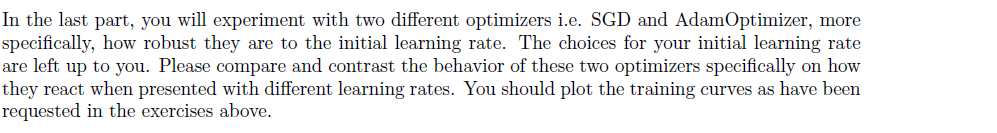

In [15]:
# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 50
batch_size= 512

transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform,download=True)
# spliting dataset into half with random indexes
indexList = random.sample(list(range(0,len(train_dataset))), (len(train_dataset)//2))
train_dataset_half = torch.utils.data.Subset(train_dataset,indexList)

test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform,download=True)
train_loader = DataLoader(dataset=train_dataset_half,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

# different setting of learning rates
learning_rate =0.001
n_total_steps = len(train_loader)
criterion = nn.NLLLoss()
grid = [('Adam',0.01),('Adam',0.001),('Adam',0.0001),('SGD',0.5),('SGD',0.1),('SGD',0.01)]

for opt,lr in grid:

    # Initialize network
    model = CNN(input_channels=in_channels, num_of_classes=num_classes).to(device)

    # Initializing Optimizer
    if(opt=='Adam'):
        optimizer= torch.optim.Adam(model.parameters(),lr=lr)
    else:
        optimizer= torch.optim.SGD(model.parameters(),lr=lr)

    # Initializing writer for tensorboard

    print('------------------------------------------------------------------------------')
    print('|----------- Experiment with Optimizer = '+str(opt)+'---Learning Rate = '+str(lr)+'----------|')
    print('------------------------------------------------------------------------------')
    desc =opt+'_'+str(lr)
    model = trainModel(model, optimizer,criterion, learning_rate, train_loader,test_loader, num_epochs, desc)

    writer = None
    epoch = None
    totalAccuracy = evalModel(model,optimizer,criterion,test_loader,epoch,writer)
    print('Final test Accuracy'+desc+':'+str(totalAccuracy))


Files already downloaded and verified
Files already downloaded and verified
------------------------------------------------------------------------------
|----------- Experiment with Optimizer = Adam---Learning Rate = 0.01----------|
------------------------------------------------------------------------------
Epoch [5/50],Train Loss: 1.9263,Train Accuracy: 0.2834,Test Loss: 1.8832,Test Accuracy: 0.3098
Epoch [10/50],Train Loss: 1.7809,Train Accuracy: 0.3401,Test Loss: 1.7784,Test Accuracy: 0.3481
Epoch [15/50],Train Loss: 1.6766,Train Accuracy: 0.3849,Test Loss: 1.7311,Test Accuracy: 0.3775
Epoch [20/50],Train Loss: 1.5892,Train Accuracy: 0.4215,Test Loss: 1.6808,Test Accuracy: 0.3856
Epoch [25/50],Train Loss: 1.5212,Train Accuracy: 0.4456,Test Loss: 1.6899,Test Accuracy: 0.3942
Epoch [30/50],Train Loss: 1.4167,Train Accuracy: 0.4830,Test Loss: 1.7430,Test Accuracy: 0.4001
Epoch [35/50],Train Loss: 1.3828,Train Accuracy: 0.4972,Test Loss: 1.8027,Test Accuracy: 0.3851
Epoch [40/50],T


#### Adam with different learning rates
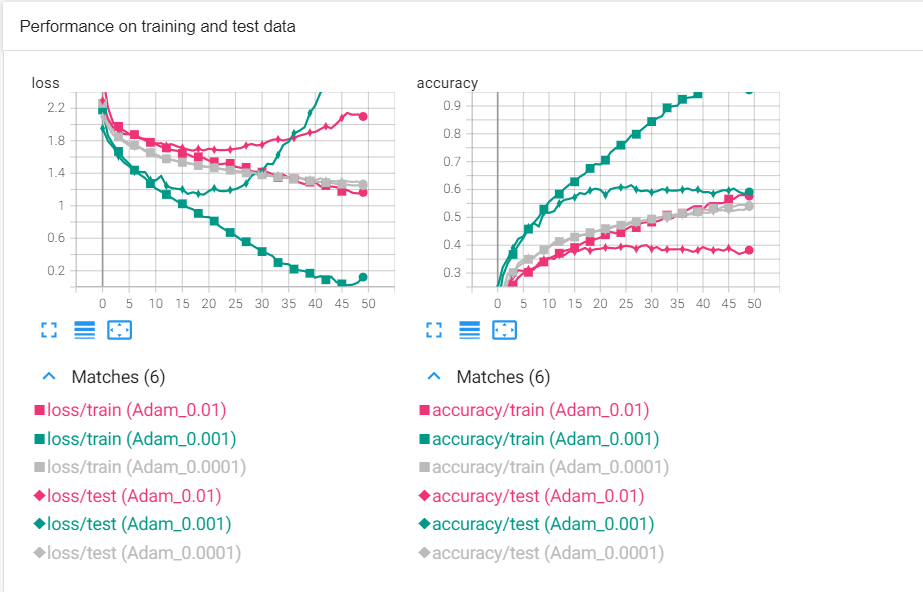

<b>Comment</b> : Adams best test accuracy is achieved with learning rate 0.001 however difference btw train and test accuracy is also hight for learning rate 0.001. With smaller learning rate 0.0001 this difference is small.However Adam is quite robust to learning rate.


#### SGD with different learning rates
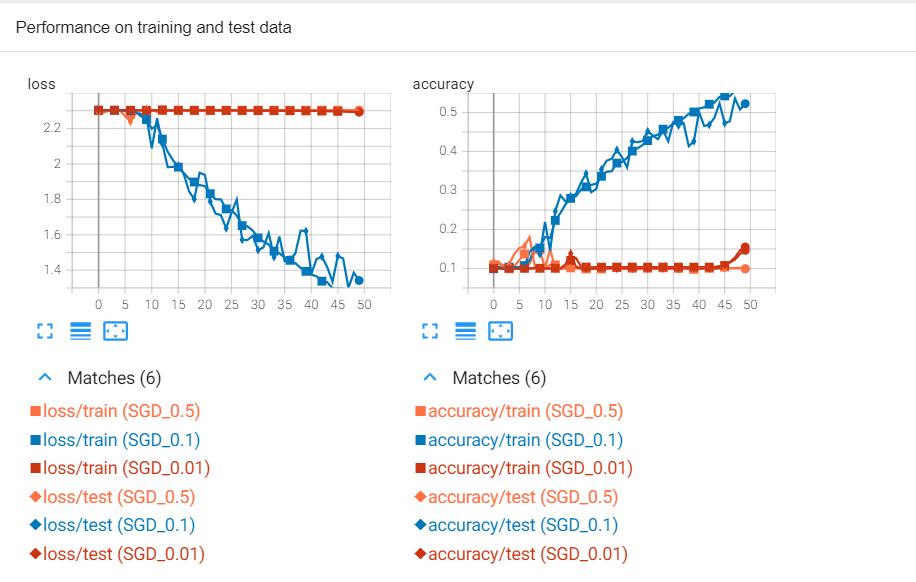

<b>Comment</b> : SGD best test accuracy is achieved with learning rate 0.1. Taking smaller learning rate, decreases the performance.


#### Adam vs SGD
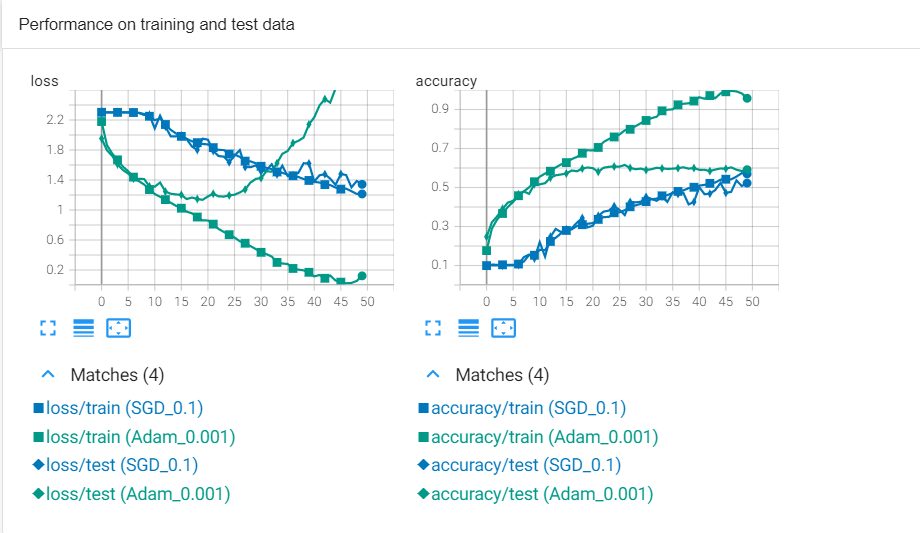

<b>Comment</b> : Adam works better on smaller learning rate in comparison to SGD which works better on 0.1. However, difference in training and test curves is smaller with SGD.